In [16]:
# %matplotlib inline
import sys
sys.path.insert(1, '/data/vision/polina/scratch/wpq/github/code_snippets')
from code_snippets.plot import plt_slices
from code_snippets.torch import torch_set_random_seed, torch_configure_cuda
from code_snippets.jpt import jpt_autoreload, jpt_full_width

jpt_autoreload()
jpt_full_width()

import matplotlib.pyplot as plt

# matplotlib.use("Agg", warn=True)

import json
import math
import os

import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
import torch.distributions as dist
from torch.optim.lr_scheduler import StepLR

from trixi.logger.experiment.pytorchexperimentlogger import PytorchExperimentLogger
from trixi.logger import PytorchVisdomLogger
from trixi.util import Config
from trixi.util.pytorchutils import set_seed

from models.enc_dec import Encoder, Generator
from data.brain_ds import BrainDataSet, load_dataset
from utils.util import smooth_tensor, normalize, find_best_val, calc_hard_dice

from brats_script import VAE, loss_function, get_inpt_grad, train, test_slice, test_pixel, model_run

In [6]:
gpu_id = '3'
patch_size = 64 # patch_size = 64
batch_size = 64
odd_class = 0
z = 256
seed = 123
log_var_std = 0.
n_epochs = 5
lr = 1e-4

model_h_size = (16, 32, 64, z)
name = 'exp_imsize=64'
exp_name = name
folder_name = name

torch_set_random_seed(seed)
device = torch_configure_cuda(gpu_id)

config = Config(
    exp_name=exp_name,
    patch_size=patch_size,
    batch_size=batch_size,
    odd_class=odd_class,
    z=z,
    seed=seed,
    log_var_std=log_var_std,
    n_epochs=n_epochs
)

input_shape = (batch_size, 1, patch_size, patch_size)

config, device, input_shape

({'exp_name': 'exp',
  'patch_size': 256,
  'batch_size': 64,
  'odd_class': 0,
  'z': 256,
  'seed': 123,
  'log_var_std': 0.0,
  'n_epochs': 5},
 device(type='cuda'),
 (64, 1, 256, 256))

In [8]:
datasets_common_args = {
    "batch_size": batch_size,
    "target_size": patch_size,
    "input_slice": [0, ],  # [1, ] previously selects T2 mri
    "add_noise": True,
    "mask_type": "gaussian",  # 0.0, ## TODO
    "elastic_deform": False,
    "rnd_crop": True,
    "rotate": True,
    "color_augment": True,
    "add_slices": 0,
}

train_set_args = {
    "base_dir": "data/hcp1200_v2/",
#     "num_batches": 3,
    "slice_offset": 50, # 20
    "num_processes": 8, # 8
}

test_set_normal_args = {
    "base_dir": "data/atlas2/",  # brats17/
#     "num_batches": 2, # 100
    "do_reshuffle": False,
    "mode": "val",
    "num_processes": 2, # 2
    "slice_offset": 30, # 20
    "label_slice": 2,
    "only_labeled_slices": False,
}

test_set_unormal_args = {
    "base_dir": "data/atlas2/",  # brats17/
#     "num_batches": 2, # 100
    "do_reshuffle": False,
    "mode": "val",
    "num_processes": 2, # 2
    "slice_offset": 30, # 20
    "label_slice": 2,
    "only_labeled_slices": True,
    "labeled_threshold": 10,
}

test_set_all_args = {
    "base_dir": "data/atlas2/",  # brats17/
#     "num_batches": 2, # 50
    "do_reshuffle": False,
    "mode": "val",
    "num_processes": 2, # 2
    "slice_offset": 30, # 20
    "label_slice": 2,
}

In [9]:
train_loader = BrainDataSet(**datasets_common_args, **train_set_args)
test_loader_normal = BrainDataSet(**datasets_common_args, **test_set_normal_args)
test_loader_abnorm = BrainDataSet(**datasets_common_args, **test_set_unormal_args)
test_loader_all = BrainDataSet(**datasets_common_args, **test_set_all_args)

In [10]:
model = VAE(input_size=input_shape[1:], h_size=model_h_size, z_dim=z).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = StepLR(optimizer, step_size=1)

In [11]:
# vlog = PytorchVisdomLogger(experiment_name=exp_name)
vlog = None
elog = PytorchExperimentLogger(base_dir=folder_name, experiment_name=exp_name)
elog.save_config(config, "config")

In [12]:

for epoch in range(1, n_epochs + 1):
    #     train(epoch, model, optimizer, train_loader, device, vlog, elog, log_var_std)
    #
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data["data"][0].float().to(device)
        optimizer.zero_grad()
        recon_batch, mu, logstd = model(data)
        loss, kl, rec = loss_function(recon_batch, data, mu, logstd, log_var_std)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx}/{len(train_loader)} ({100. * batch_idx / len(train_loader):.0f}%)]'
                  f'\tLoss: {loss.item() / len(data):.6f}'
                  f'\tKL,Rec,Total: {torch.mean(kl).item():.3f}, {torch.mean(rec).item():.3f}, {loss.item():.3f}')
            
            # vlog.show_value(torch.mean(kl).item(), name="Kl-loss", tag="Losses")
            # vlog.show_value(torch.mean(rec).item(), name="Rec-loss", tag="Losses")
            # vlog.show_value(loss.item(), name="Total-loss", tag="Losses")

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader)))
    


Reshuffle...
Train Epoch: 1 [0/3 (0%)]	Loss: 1056.103271	KL,Rec,Total: 561.353, 67029.250, 67590.609
====> Epoch: 1 Average loss: 68246.4089
Reshuffle...
Train Epoch: 2 [0/3 (0%)]	Loss: 1050.456055	KL,Rec,Total: 390.860, 66838.328, 67229.188
====> Epoch: 2 Average loss: 68049.3490
Reshuffle...
Train Epoch: 3 [0/3 (0%)]	Loss: 1077.588257	KL,Rec,Total: 165.527, 68800.117, 68965.648
====> Epoch: 3 Average loss: 68600.4557
Reshuffle...
Train Epoch: 4 [0/3 (0%)]	Loss: 1051.240112	KL,Rec,Total: 73.980, 67205.391, 67279.367
====> Epoch: 4 Average loss: 69133.2682
Reshuffle...
Train Epoch: 5 [0/3 (0%)]	Loss: 1035.193848	KL,Rec,Total: 19.418, 66232.984, 66252.406
====> Epoch: 5 Average loss: 67021.0130


In [13]:
kl_roc, rec_roc, loss_roc, kl_pr, rec_pr, loss_pr, test_loss = test_slice(
    model, test_loader_normal,
    test_loader_abnorm, device,
    vlog, elog, input_shape, batch_size,
    log_var_std)

====> Test set loss: 64976.3647


In [14]:

with open(os.path.join(elog.result_dir, "results.json"), "w") as file_:
    json.dump({
        "kl_roc": kl_roc, "rec_roc": rec_roc, "loss_roc": loss_roc,
        "kl_pr": kl_pr, "rec_pr": rec_pr, "loss_pr": loss_pr,
    }, file_, indent=4)

elog.save_model(model, "vae")

In [15]:
test_pixel(model, test_loader_all, device, vlog, elog, input_shape, batch_size, log_var_std)

print("All done....")

All done....


(64, 260, 260)


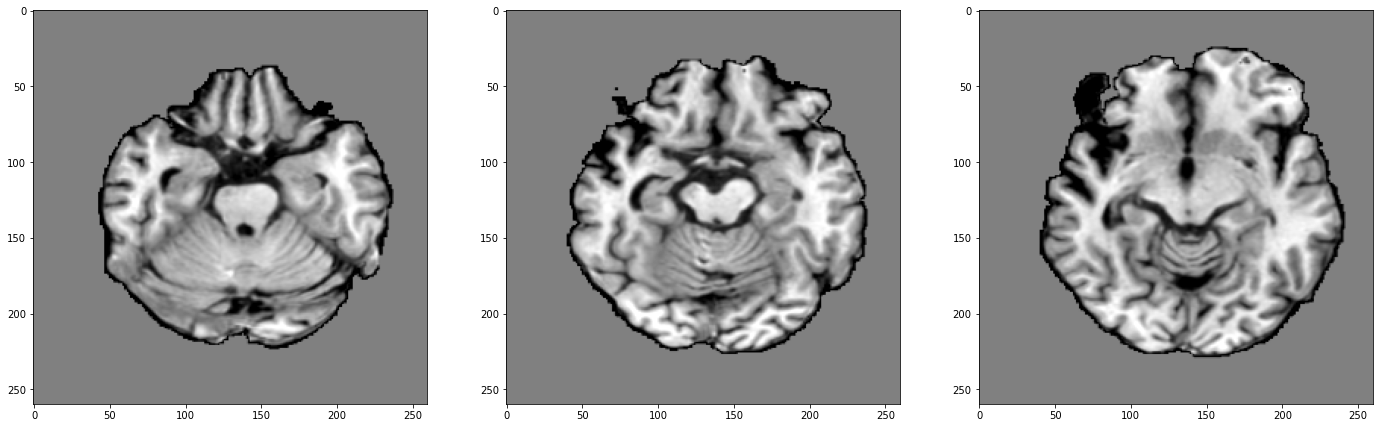

In [9]:
# x = train_loader[0]['data'].numpy().squeeze()
# x = test_loader_normal[0]['data'].numpy().squeeze()
# x = test_loader_abnorm[0]['data'].numpy().squeeze()
# x = test_loader_all[0]['data'].numpy().squeeze()

# print(x.shape)

# fig, axs = plt.subplots(1,3,figsize=(24,8))

# for i,k in enumerate([0,10,20]):
#     ax = axs[i]
#     ax.imshow(x[k], cmap='gray')

# fig

# for batch_idx, data in enumerate(train_loader):
#     data = data['data'][0].float()  # (1, 64, 1, 260, 260) -> (64, 1, 260, 260)
#     print(data.numpy().squeeze().shape)
#     break

In [28]:
# # files, file_len, slices = load_dataset(base_dir=train_set_args['base_dir'],
# #                                       pattern='*.npy',
# #                                       slice_offset=train_set_args['slice_offset'],
# #                                       only_labeled_slices=None,
# #                                       label_slice=None,
# #                                       labeled_threshold=10)
# import fnmatch

# #### hcp
# base_dir='data/hcp1200_v2'
# pattern='*.npy'
# slice_offset=50
# only_labeled_slices=None
# label_slice=None
# labeled_threshold=10
# #### atlas2 
# base_dir='data/atlas2'
# # pattern='*.npy'
# slice_offset=30
# only_labeled_slices=False # False selects healthy slices, True selects lesion slices
# label_slice=2
# labeled_threshold=10
# ####


# fls = []
# files_len = []
# slices = []

# for root, dirs, files in os.walk(base_dir):
#     for i, filename in enumerate(sorted(fnmatch.filter(files, pattern))):
#         npy_file = os.path.join(root, filename) # data/atlas2/sub-r001s001_ses-1.npy 
#         numpy_array = np.load(npy_file, mmap_mode="r") # (3, 260, 320, 260)

#         fls.append(npy_file)
#         files_len.append(numpy_array.shape[1])

#         if only_labeled_slices is None:
#             slices.extend([(i, j) for j in range(slice_offset, files_len[-1] - slice_offset)])
#         else:
#             assert label_slice is not None # label_slice access into lesion_mask

#             for s_idx in range(slice_offset, numpy_array.shape[1] - slice_offset):

#                 # `pixel_sum` is #pixels where lesion mask is active.
#                 # `only_labeled_slices=True`: selects 
#                 # 
#                 pixel_sum = np.sum(numpy_array[label_slice, s_idx] > 0.1)
#                 if pixel_sum > labeled_threshold:
#                     if only_labeled_slices is True:
#                         slices.append((i, s_idx))
#                 elif pixel_sum == 0:
#                     if only_labeled_slices is False:
#                         slices.append((i, s_idx))

#         break

# print(fls, files_len, slices, len(slices))

['data/atlas2/sub-r001s001_ses-1.npy'] [260] [(0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 200), (0, 201), (0, 202), (0, 203), (0, 204), (0, 205), (0, 206), (0, 207), (0, 208), (0, 209), (0, 210), (0, 211), (0, 212), (0, 213), (0, 214), (0, 215), (0, 216), (0, 217), (0, 218), (0, 219), (0, 220), (0, 221), (0, 222), (0, 223), (0, 224), (0, 225), (0, 226), (0, 227), (0, 228), (0, 229)] 68


In [58]:
# self = train_loader.data_loader
# # self = test_loader_abnorm.data_loader

# ks = ['files', 'slices', 'batch_size', 'use_next', 'slice_idxs', 'n_items', 
#       'num_batches', 'input_slice', 'label_slice', 'add_slices', 'np_data']

# for k in ks:
#     attr = getattr(self, k)
#     if isinstance(attr, list):
#         print(f'{k}\t {len(attr)}, {attr[:5]}')
#     else:
#         print(f'{k}\t {attr}')
# print('\n')

# # Idea is `loader.__get_item__(self, i)` retrieves `loader.slices[i]`
# #
# assert(self.num_batches == (len(self.slices) // self.batch_size))
# #
# #
# # `slice_offset` exists to prevent using blank slices ...
# # self.add_slices := 0, whether input image has lots of slices
# # self.input_slice := [0,] picks what data type in np file, i.e., T1/T2/mask/lesion_mask
# # self.slice_idxs := 1...#slices. 
# #     - shuffling this array shuffles the data order.
# #     - indexes into self.np_data
# # self.np_data := [1...#vols] \prod [20...#slices/vol-20]

# # def __getitem__(self, item):
# item = 0
# start_idx = (item * self.batch_size) % self.data_len
# stop_idx  = ((item + 1) * self.batch_size) % self.data_len
# idxs = self.slice_idxs[start_idx:stop_idx]
# open_array = self.np_data[idxs]

# # def get_data_from_array(self, open_array):

# data = []
# fnames = []
# slice_idxs = []
# labels = []

# for slice in open_array: # [0,20]
#     fn_name = self.files[slice[0]] # data/hcp1200/100206.npy | data/atlas2/sub-r001s001_ses-1.npy
#     slice_idx = slice[1] # 20

#     # shape=(3, 260, 320, 260)
#     numpy_array = np.load(fn_name, mmap_mode="r")
#     # shape=(1, 1, 320, 260)
#     numpy_slice = numpy_array[self.input_slice,
#                               slice_idx - self.add_slices:slice_idx + self.add_slices + 1, ]
#     data.append(numpy_slice)

#     if self.label_slice is not None:
#         label_slice = numpy_array[self.label_slice,
#                                   slice_idx - self.add_slices:slice_idx + self.add_slices + 1, ]
#         labels.append(label_slice)

#     fnames.append(fn_name)
#     slice_idxs.append(slice_idx / 200.) # not really used in training code.
#     del numpy_array


# ret_dict = {'data': data,  # [ndarray,...], transform handles stacking and tranforming to batched tensor.
#             'fnames': fnames, 
#             'slice_idxs': slice_idxs}
# if self.label_slice is not None:
#     ret_dict['seg'] = labels

# ret_dict.keys()


files	 1064, ['data/hcp1200_v2/100206.npy', 'data/hcp1200_v2/100307.npy', 'data/hcp1200_v2/100408.npy', 'data/hcp1200_v2/100610.npy', 'data/hcp1200_v2/101006.npy']
slices	 170240, [(0, 50), (0, 51), (0, 52), (0, 53), (0, 54)]
batch_size	 64
use_next	 False
slice_idxs	 170240, [71584, 163882, 113298, 58460, 80117]
n_items	 2660
num_batches	 2660
input_slice	 1, [0]
label_slice	 None
add_slices	 0
np_data	 [[   0   50]
 [   0   51]
 [   0   52]
 ...
 [1063  207]
 [1063  208]
 [1063  209]]




dict_keys(['data', 'fnames', 'slice_idxs'])